# Predicting scalar coupling constant between two atoms in different organic molecules

### Imports

In [1]:
import os
import pandas as pd
import inspect
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Activation, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from sklearn.metrics import mean_absolute_error as mae
from numpy.random import seed
import keras.backend as K
from keras.layers.normalization import BatchNormalization
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats as sp
from sklearn.externals.joblib import parallel_backend
import keras.backend as K
import tensorflow as tf
from sklearn.model_selection import ParameterSampler
from keras import optimizers
import random
from biopandas.mol2 import PandasMol2
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from skopt import BayesSearchCV
from skopt.space import Real
from skopt.space import Integer
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
/home/dionizije/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Data analysis

### Changing directory and setting seed for random operations

In [23]:
seed(0)
os.chdir('/home/dionizije/Desktop/Code/Predicting molecular properties')

### Loading the train set and structure of the molecules

In [13]:
train = pd.read_csv('train.csv', index_col = 'id') 
structures = pd.read_csv('structures.csv') 

In [15]:
train.head(5) #Data provided in the train set

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [16]:
structures.head(5) #Data provided in the structure files

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [17]:
print('Missing values in training set = {}'.format(train.isnull().sum().sum())) 
print('Missing values in structures = {}'.format(structures.isnull().sum().sum()))

Missing values in training set = 0
Missing values in structures = 0


Checks for missing data in the structures and training set

In [23]:
print('Number of molecules in the training set molecules = {}'.format(train.molecule_name.nunique()))
print('Unique scalar coupling types = {}'.format(train.type.unique()))

Number of molecules in the training set molecules = 85003
Unique scalar coupling types = ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN']


### Distribution of the scalar coupling constant in the training data

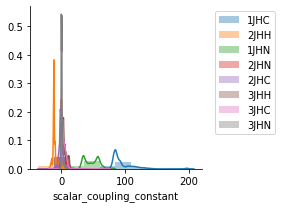

In [24]:
def distplot_with_hue(df, x, hue, hist=True, kde=True):
    _, bins = np.histogram(df[x])
    g = sns.FacetGrid(df, hue=hue)
    g = g.map(sns.distplot, x, bins=bins, hist=hist, kde=kde)
    g.ax.legend(loc=2, bbox_to_anchor=(1.05, 1))
    
distplot_with_hue(train, 'scalar_coupling_constant', 'type')

Distribution of the scalar coupling constant by molecules types -> some values are distinct while others are overlapped

### Extracting features from biopandas module --> Atom hybridization, distances, ligand types

In [27]:
def mol_2_files():
    """Features from biopandas from mol2/xyz structure files"""
    files = []
    for file in os.listdir('/home/dionizije/Desktop/Code/Predicting molecular properties/mol'):
        if file.endswith('.mol2'):
            files.append(file)
            
    molecules = []
    for molecule in files:
        try: #try statement, because there is a .mol2 file which is not a molecule and stops execution
            mol2_object = PandasMol2().read_mol2(path = '/home/dionizije/Desktop/Code/Predicting molecular properties/mol/' + molecule)
            molecule_name = molecule.rsplit(".", 1)[0] #gets rid of the extension
            molecule_name_column = [molecule_name] * int(len(mol2_object.df)) #list for molecule name column
            df_object = mol2_object.df #gets dataframe object
            df_object['molecule_name'] = molecule_name_column
            distances = mol2_object.distance() #distance from 0,0,0 reference point
            df_object['dist_from_refp'] = distances 
            df_object['atom_id'] = df_object['atom_id'] - 1 #changing indices to start from 0
            df_object.drop(['x', 'y', 'z'], axis = 1, inplace = True) #drops coordinates --> already in structures file
            df_object = df_object.rename(columns = {'atom_id': 'atom_index'})
            molecules.append(df_object) 
        except:
            pass
    df_molecules = pd.concat(molecules)
    return df_molecules

df_molecules = mol_2_files() 

In [28]:
df_molecules.head()

,atom_index,atom_name,atom_type,subst_id,subst_name,charge,molecule_name,dist_from_refp
0,0,C,C.3,1,LIG1,-0.0649,dsgdb9nsd_118835,1.565290
1,1,C,C.3,1,LIG1,-0.0504,dsgdb9nsd_118835,0.306451
2,2,C,C.3,1,LIG1,-0.0097,dsgdb9nsd_118835,1.522293
3,3,C,C.3,1,LIG1,-0.0182,dsgdb9nsd_118835,2.475827
4,4,C,C.3,1,LIG1,0.0714,dsgdb9nsd_118835,2.570540


In [29]:
df_molecules.to_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/df_molecules.csv')

Saving bigger dataframes to disk in case of memory crashes.

Merging features from df_molecules to structure files and adding structure information to the training set

In [30]:
def merge_mol2():
    """Merges molecules data from biopandas to structures file"""
    data = pd.merge(structures, df_molecules, how = 'left',
                    right_on = ['molecule_name', 'atom_index'],
                    left_on = ['molecule_name', 'atom_index'])
    data = data.drop(['atom_name', 'subst_id'], axis = 1)
    return data

structures = merge_mol2()
del(df_molecules) #del for releasing from memory


In [31]:
structures.head()

,molecule_name,atom_index,atom,x,y,z,atom_type,subst_name,charge,dist_from_refp
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,C.3,LIG1,-0.0776,1.085904
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,H,LIG1,0.0194,0.006696
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,H,LIG1,0.0194,1.779395
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,H,LIG1,0.0194,1.776555
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,H,LIG1,0.0194,1.778619


In [32]:
def merge_structures(data, atom_index):
    """Merges atom data from structures to atom data in the training sets"""
    data = pd.merge(data, structures, how = 'left',
                    left_on = ['molecule_name', 'atom_index_{}'.format(atom_index)],
                    right_on = ['molecule_name', 'atom_index'])
    data = data.drop('atom_index', axis = 1)
    data = data.rename(columns = {'atom': 'atom_{}'.format(atom_index),
                                  'x': 'x_{}'.format(atom_index),
                                  'y': 'y_{}'.format(atom_index),
                                  'z': 'z_{}'.format(atom_index)})
    return data

train = merge_structures(train, 0)
train = merge_structures(train, 1)

In [33]:
train.head()

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_type_x,...,charge_x,dist_from_refp_x,atom_1,x_1,y_1,z_1,atom_type_y,subst_name_y,charge_y,dist_from_refp_y
0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,H,...,0.0194,0.006696,C,-0.012698,1.085804,0.008001,C.3,LIG1,-0.0776,1.085904
1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,...,0.0194,0.006696,H,1.011731,1.463751,0.000277,H,LIG1,0.0194,1.779395
2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,...,0.0194,0.006696,H,-0.540815,1.447527,-0.876644,H,LIG1,0.0194,1.776555
3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,...,0.0194,0.006696,H,-0.523814,1.437933,0.906397,H,LIG1,0.0194,1.778619
4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,H,...,0.0194,1.779395,C,-0.012698,1.085804,0.008001,C.3,LIG1,-0.0776,1.085904


In [34]:
train.to_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/train_final.csv')

In [35]:
del(structures)


Defining a function for adding additional features, and splitting the training set to features and target
Added features are distance between coupling atoms, dipole moments, atomic radius, electronegativity, angles between point vectors.
Categorical variables are one hot encoded.

In [25]:
def preprocessing_features(data):
    
    #Distance between coupling atoms
    data['dist_coupling_atoms'] = ((data['x_1'] - data['x_0'])**2 + (data['y_1'] - data['y_0'])**2 + (data['z_1'] - data['z_0'])**2)**1/2
    
    #adding dipole moments
    dipole_moments = pd.read_csv('dipole_moments.csv')
    data = pd.merge(data, dipole_moments, how = 'inner', left_on = ['molecule_name'],
                     right_on = ['molecule_name'])
    data.rename(columns  = {'X_x': 'X_dipole', 'Y_x': 'Y_dipole', 'Z_x': 'Z_dipole'}, inplace = True)
    
    #adding atomic radius
    atomic_radius = pd.DataFrame({'radius' : [67, 53, 56, 48, 42]},
                             index = ['C', 'H', 'N', 'O', 'F'])
    
    data = data.merge(atomic_radius, left_on = ['atom_0'], right_on = atomic_radius.index)
    data = data.rename(columns = {'atomic_radius' : 'radius_atom_0'})
    
    #adding atomic radius
    data = data.merge(atomic_radius, left_on = ['atom_1'], right_on = atomic_radius.index)
    data = data.rename(columns = {'atomic_radius' : 'radius_atom_1'})
    
    #adding electronegativity
    electronegativity = pd.DataFrame({'electronegativity' : [2.55, 2.20, 3.04, 3.44, 3.98]},
                                  index = ['C', 'H', 'N', 'O', 'F'])
    
    data = data.join(electronegativity, how = 'left', on = ['atom_0'])
    data = data.rename(columns = {'electronegativity' : 'electronegativity_atom_0'})
    
    #adding electronegativity
    data = data.join(electronegativity, how = 'left', on = ['atom_1'])
    data = data.rename(columns = {'electronegativity' : 'electronegativity_atom_1'})
    
    
    data.drop(columns = ['atom_index_0', 'atom_index_1', 'atom_0', 'atom_1'], inplace = True)
    
    #dummies and dropping columns
    X = data.drop(columns = 'molecule_name')
    X = pd.get_dummies(X, columns = ['type', 'atom_type_x', 'atom_type_y', 'subst_name_x',
                                     'subst_name_y'], drop_first = True)
    y = X['scalar_coupling_constant']
    X.drop(columns = 'scalar_coupling_constant', inplace = True)
    
    def calculate_angles(X):
        "Calculates angles between two unit vectors"""
        def unit_vector(vector):
            """ Returns the unit vector of the vector.  """
            return vector / np.linalg.norm(vector)
    
        def angle_btw_vectors(v1, v2):
            """ Returns the angle in radians between vectors 'v1' and 'v2'::"""
            v1_u = unit_vector(v1)
            v2_u = unit_vector(v2)
            return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    
        vectors_0 = []
        for i in range(0, len(X)):
            x = X['x_0'].iloc[i]
            y = X['y_0'].iloc[i]
            z = X['z_0'].iloc[i]
            vector_coords = [x, y, z]
            units = unit_vector(vector_coords)
            vectors_0.append(units)         
        
        vectors_1 = []
        for i in range(0, len(X)):
            x = X['x_1'].iloc[i]
            y = X['y_1'].iloc[i]
            z = X['z_1'].iloc[i]
            vector_coords = [x, y, z]
            units = unit_vector(vector_coords)
            vectors_1.append(units)
        
        angles = []
        for i in range(0, len(vectors_0)):
            angle = angle_btw_vectors(vectors_0[i], vectors_1[i])
            angles.append(angle)
            
        return angles
    
    angles = calculate_angles(X)
    X['angles'] = angles
    
    return X,y 

In [37]:
X, y = preprocessing_features(train)

In [38]:
X.head()

,x_0,y_0,z_0,charge_x,dist_from_refp_x,x_1,y_1,z_1,charge_y,dist_from_refp_y,...,subst_name_y_LEU1,subst_name_y_LIG1,subst_name_y_PRO1,subst_name_y_SER1,subst_name_y_THR1,subst_name_y_UNK0,subst_name_y_UNK1,subst_name_y_UNK2,subst_name_y_VAL1,angles
0,0.002150,-0.006031,0.001976,0.0194,0.006696,-0.012698,1.085804,0.008001,-0.0776,1.085904,...,0,1,0,0,0,0,0,0,0,2.694086
1,1.011731,1.463751,0.000277,0.0194,1.779395,-0.012698,1.085804,0.008001,-0.0776,1.085904,...,0,1,0,0,0,0,0,0,0,0.616520
2,-0.540815,1.447527,-0.876644,0.0194,1.776555,-0.012698,1.085804,0.008001,-0.0776,1.085904,...,0,1,0,0,0,0,0,0,0,0.618726
3,-0.523814,1.437933,0.906397,0.0194,1.778619,-0.012698,1.085804,0.008001,-0.0776,1.085904,...,0,1,0,0,0,0,0,0,0,0.617095
4,-0.027803,2.198949,0.014154,0.1537,2.199122,-0.013324,1.132466,0.008276,0.0464,1.132609,...,0,1,0,0,0,0,0,0,0,0.001237


In [39]:
del(train)
X.to_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/X_final.csv')
np.savetxt('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/y_final.csv', y, delimiter = ",", )

Setting aside data for testing

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

X_train.to_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/X_train_final.csv')
np.savetxt('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/y_train_final.csv', y_train, delimiter = ",")

X_test.to_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/X_test_final.csv')
np.savetxt('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/y_test_final.csv', y_test, delimiter = ",")

## Model optimization

Functions for cross validation of the training set and mean absolute error between the predictions and the test set

In [43]:
def evaluation(model, X_train, y_train):
    """Cross validation on the training set"""
    model = KerasRegressor(build_fn = model, epochs = 50)
    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = pd.DataFrame(cross_validate(model, X_train, y_train, scoring = scoring, cv = 3))
    return scores

In [56]:
def test_evaluation(model, X_train, y_train, X_test, y_test):
    """Evaluation of the model (MAE) on the test set"""
    model = model()
    early_stopper = EarlyStopping(patience=15, monitor='val_loss', min_delta=0, mode='min', restore_best_weights = True)
    history = model.fit(X_train, y_train, callbacks = [early_stopper], validation_data = (X_test, y_test))
    y_pred = model.predict(X_test)
    mean_absolute_error = mae(y_test, y_pred)
    print('Mean absolute error on the test set is {}'.format(mean_absolute_error))
    return history, mean_absolute_error

### Model with 1 hidden layer and Adam optimizer, all default values

In [57]:
def model_1():
    """ Baseline model + 1 hidden layer + dropout"""
    K.backend()
    model = Sequential()
    
    #input layer
    model.add(Dense(int(X_train.shape[1]), input_dim = int(X_train.shape[1])))
    model.add(Activation('relu'))
    
    #hidden layer
    model.add(Dense(int(X_train.shape[1]/2)))
    model.add(Activation('relu'))

    
    #output layer
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model

In [ ]:
X_train = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/X_train_final.csv', index_col = 0)
y_train = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/y_train_final.csv', header = None)
X_test = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/X_test_final.csv', index_col = 0)
y_test = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/y_test_final.csv', header = None)

#### Cross validation on the training set of the model with default parameters

In [ ]:
model_1_cross_valid_score = evaluation(model_1, X_train, y_train) #Calculates the cross validation scores

In [8]:
model_1_cross_valid_score = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_1.csv',
                                       index_col = [0])
model_1_cross_valid_score

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error
0,6841.771627,36.589580,-9.189185,-1.978522
1,6964.458209,31.311657,-10.181463,-2.116645
2,7324.525281,33.686052,-10.904482,-2.126167


#### Evaluating the model on the test set and plotting learning history

In [ ]:
model_1_mae, history_model_1 = test_evaluation(model_1, X_train, y_train, X_test, y_test) #Returns history and MAE on test set

In [9]:
model_1_mae_score = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_1_mae.csv',
                               index_col = [0])
model_1_mae_score

,model_1_mae
0,1.973654


Mean absolute error is basically the same as on the training set

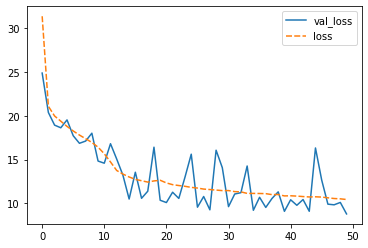

In [4]:
model_1_history = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_1_history.csv', 
                             index_col = [0])
sns.lineplot(data = model_1_history)

Model hasn't converged after 50 epochs, and the loss on the validation set is fluctuating, which should be improved with hyper-parameter optimization and regularization.

### Model 2 - default values with added batch normalization for regularization

In [12]:
def model_2():
    K.backend()
    model = Sequential()
    #input layer
    model.add(Dense(int(X_train.shape[1]), input_dim = int(X_train.shape[1])))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    #hidden layer
    model.add(Dense(int(X_train.shape[1]/2)))
    model.add(Activation('relu'))

    
    #output layer
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model

In [ ]:
model_2_score = evaluation(model_2, X_train, y_train) #Cross validation on the default model with BN

In [13]:
model_1_cross_valid_score = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_2.csv',
                                        index_col = [0])
model_1_cross_valid_score

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error
0,9037.327654,52.054146,-21.966199,-2.910550
1,9283.378555,45.239434,-20.786696,-2.856885
2,9487.053614,50.274308,-18.566012,-2.636477


With added batch normalization : training time is increased and the scores are worse than on the default model

In [14]:
model_2_mae_score = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_2_mae.csv',
                               index_col = [0])
model_2_mae_score

,model_2_mae
0,2.580056


Mean absolute error on the test set is also higher with batch normalization

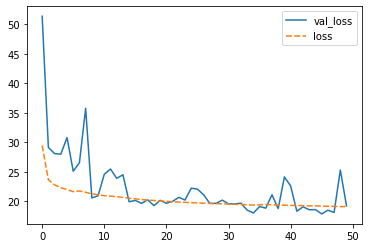

In [3]:
model_2_history = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_2_history.csv', 
                             index_col = [0])
sns.lineplot(data = model_2_history)

Fluctuation in validation set loss has been reduced, but at the cost of accuracy

In [13]:
model_histories = pd.DataFrame({'model_1_loss': model_1_history['loss'],
                                'model_2_loss': model_2_history['loss'], 
                                'model_1_val_loss': model_1_history['val_loss'], 
                                'model_2_val_loss': model_2_history['val_loss']})

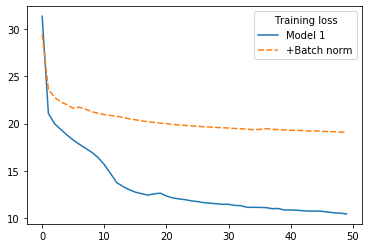

In [19]:
plot = sns.lineplot(data = [model_histories['model_1_loss'], model_histories['model_2_loss']])
labels = ['Model 1', '+ Batch norm']
plt.legend(title = 'Training loss', labels = ['Model 1', '+Batch norm'])


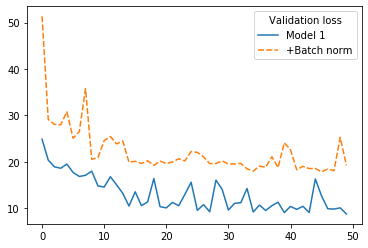

In [20]:
plot = sns.lineplot(data = [model_histories['model_1_val_loss'], model_histories['model_2_val_loss']])
labels = ['Model 1', '+ Batch norm']
plt.legend(title = 'Validation loss', labels = ['Model 1', '+Batch norm'])


Comparison plots of validation and training losses of models with and without batch normalization where it's clear that there are less fluctuations with batch normalization, but accuracy is lower

### Data subsampling for paramater tuning

In [22]:
def subsampling(data, number_of_samples):
    """ Samples the same number of values for each type to reduce memory issues and reduce training time"""
    
    unique_types = list(train['type'].unique())
    num_of_each_type = int(number_of_samples/len(unique_types))
    subsampled_types = []
    for types in unique_types:
        samples = train.query("type ==  '{}'".format(types)).sample(num_of_each_type)
        subsampled_types.append(samples)
    train_subsampled = pd.concat(subsampled_types)
    
    #Stats of scalar coupling constant
    data_distribution = pd.DataFrame(train['scalar_coupling_constant'].describe())
    data_distribution.rename(columns = {'scalar_coupling_constant': 'Train_scalar_coupling_constant'}, 
                             inplace = True)
    
    data_subsample_distribution = pd.DataFrame(train_subsampled['scalar_coupling_constant'].describe())
    data_subsample_distribution.rename(columns = {'scalar_coupling_constant': 'Train_subsample_scalar_coupling_constant'},
                                       inplace = True)
    
    #Distribution plot
    fig, ax = plt.subplots()
    sns.distplot(train['scalar_coupling_constant'], ax = ax, label = 'Train')
    sns.distplot(train_subsampled['scalar_coupling_constant'], ax = ax, label = 'Train_subsampled')
    ax.legend()
    plt.title('Distribution of whole train dataset vs subsampled')
    plt.show()
    
    print(data_distribution)
    print(data_subsample_distribution)
    return train_subsampled

In [24]:
train = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/train_final.csv', 
                   index_col = [0])

/home/dionizije/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


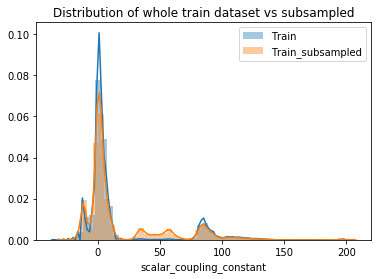

       Train_scalar_coupling_constant
count                    4.658147e+06
mean                     1.592165e+01
std                      3.494198e+01
min                     -3.621860e+01
25%                     -2.549780e-01
50%                      2.281130e+00
75%                      7.390655e+00
max                      2.048800e+02
       Train_subsample_scalar_coupling_constant
count                             300000.000000
mean                                  18.066605
std                                   34.188050
min                                  -26.899000
25%                                   -0.095366
50%                                    2.507215
75%                                   29.319300
max                                  202.129000


In [27]:
train_subsampled = subsampling(train, 300000)

Comparison of the distributions of scalar coupling constant in the whole training set and the subsampled training set. 

In [29]:
X_subsampled, y_subsampled = preprocessing_features(train_subsampled)
y_subsampled = y_subsampled.values.reshape(-1,1)

#### Cross validation of model 1 on subsampled data

In [30]:
def model_1_subsampled():
    """ Baseline model + 1 hidden layer + dropout"""
    K.backend()
    model = Sequential()
    
    #input layer
    model.add(Dense(int(X_subsampled.shape[1]), input_dim = int(X_subsampled.shape[1])))
    model.add(Activation('relu'))
    
    #hidden layer
    model.add(Dense(int(X_subsampled.shape[1]/2)))
    model.add(Activation('relu'))

    
    #output layer
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model

In [44]:
model_1_score_subsampled = evaluation(model_1_subsampled, X_subsampled, y_subsampled)

Epoch 1/50
200000/200000 [==============================] - 31s 154us/step - loss: 32.2744
Epoch 2/50
200000/200000 [==============================] - 31s 154us/step - loss: 13.7282
Epoch 3/50
200000/200000 [==============================] - 31s 155us/step - loss: 13.1197
Epoch 4/50
200000/200000 [==============================] - 31s 154us/step - loss: 12.6416
Epoch 5/50
200000/200000 [==============================] - 31s 154us/step - loss: 12.0329
Epoch 6/50
200000/200000 [==============================] - 31s 154us/step - loss: 11.3974
Epoch 7/50
200000/200000 [==============================] - 31s 154us/step - loss: 10.8701
Epoch 8/50
200000/200000 [==============================] - 31s 153us/step - loss: 10.4468
Epoch 9/50
200000/200000 [==============================] - 31s 154us/step - loss: 10.0309
Epoch 10/50
200000/200000 [==============================] - 31s 153us/step - loss: 9.6223
Epoch 11/50
200000/200000 [==============================] - 30s 151us/step - loss: 9.2551

200000/200000 [==============================] - 30s 151us/step - loss: 22.5844
Epoch 41/50
200000/200000 [==============================] - 30s 151us/step - loss: 22.5285
Epoch 42/50
200000/200000 [==============================] - 30s 152us/step - loss: 22.4012
Epoch 43/50
200000/200000 [==============================] - 30s 152us/step - loss: 22.2590
Epoch 44/50
200000/200000 [==============================] - 30s 152us/step - loss: 22.3412
Epoch 45/50
200000/200000 [==============================] - 31s 153us/step - loss: 22.3568
Epoch 46/50
200000/200000 [==============================] - 30s 151us/step - loss: 22.2837
Epoch 47/50
200000/200000 [==============================] - 30s 150us/step - loss: 22.1878
Epoch 48/50
200000/200000 [==============================] - 30s 150us/step - loss: 22.1354
Epoch 49/50
200000/200000 [==============================] - 30s 151us/step - loss: 21.9441
Epoch 50/50
200000/200000 [==============================] - 30s 151us/step - loss: 21.9190


In [45]:
model_1_score_subsampled

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error
0,1532.407646,6.323515,-5544.947285,-46.531128
1,1488.996960,7.011984,-11.016185,-2.179924
2,1507.588302,7.084641,-544.430985,-15.630765


Large difference between MSE on the training and test folds; model is overfitting and there is a lot of fluctuation between folds. 

#### Grid search of kernel initializers and number of neurons in the hidden layer on the subsampled data

In [49]:
def model_2_subsampled(kernel_init_1, kernel_init_2, kernel_init_3):
    K.backend()
    model = Sequential()
    
    #input layer
    model.add(Dense(int(X_subsampled.shape[1]), input_dim = int(X_subsampled.shape[1]),
                    kernel_initializer = kernel_init_1))
    model.add(Activation('relu'))
    
    #hidden layer
    model.add(Dense(int(X_subsampled.shape[1]/2), kernel_initializer = kernel_init_2))
    model.add(Activation('relu'))

    
    #output layer
    model.add(Dense(1, kernel_initializer = kernel_init_3))
    adam = optimizers.Adam()
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model

In [ ]:
model = KerasRegressor(build_fn = model_2_subsampled, epochs = 50)
parameters = {'kernel_init_1': ['glorot_normal', 'he_normal'],
              'kernel_init_2': ['glorot_normal', 'he_normal'],
              'kernel_init_3': ['glorot_normal', 'he_normal']}
grid_search = GridSearchCV(model, param_grid = parameters,
                           n_jobs = 1, cv = 3, iid = False, scoring = 'neg_mean_squared_error')
grid_search.fit(X_subsampled, y_subsampled)
grid_search_init_results_df = pd.DataFrame(grid_search.cv_results_)
init_best_params = grid_search.best_params_

Epoch 1/50
200000/200000 [==============================] - 46s 231us/step - loss: 31.2294
Epoch 2/50
200000/200000 [==============================] - 43s 216us/step - loss: 14.4507
Epoch 3/50
200000/200000 [==============================] - 43s 216us/step - loss: 13.6971
Epoch 4/50
200000/200000 [==============================] - 43s 216us/step - loss: 13.1604
Epoch 5/50
200000/200000 [==============================] - 44s 218us/step - loss: 12.5746
Epoch 6/50
200000/200000 [==============================] - 44s 219us/step - loss: 11.8828
Epoch 7/50
200000/200000 [==============================] - 44s 222us/step - loss: 11.3099
Epoch 8/50
200000/200000 [==============================] - 44s 220us/step - loss: 10.9363
Epoch 9/50
200000/200000 [==============================] - 44s 219us/step - loss: 10.6166
Epoch 10/50
200000/200000 [==============================] - 45s 223us/step - loss: 10.2929
Epoch 11/50
200000/200000 [==============================] - 44s 219us/step - loss: 9.903

200000/200000 [==============================] - 43s 215us/step - loss: 22.6419
Epoch 41/50
200000/200000 [==============================] - 43s 216us/step - loss: 22.5600
Epoch 42/50
200000/200000 [==============================] - 43s 216us/step - loss: 22.5628
Epoch 43/50
200000/200000 [==============================] - 43s 216us/step - loss: 22.4746
Epoch 44/50
200000/200000 [==============================] - 43s 215us/step - loss: 22.5415
Epoch 45/50
200000/200000 [==============================] - 43s 216us/step - loss: 22.4109
Epoch 46/50
200000/200000 [==============================] - 43s 214us/step - loss: 22.2328
Epoch 47/50
200000/200000 [==============================] - 43s 215us/step - loss: 22.2186
Epoch 48/50
200000/200000 [==============================] - 43s 216us/step - loss: 22.2245
Epoch 49/50
200000/200000 [==============================] - 43s 215us/step - loss: 22.1840
Epoch 50/50
200000/200000 [==============================] - 43s 215us/step - loss: 22.1253


200000/200000 [==============================] - 44s 219us/step - loss: 7.3505
Epoch 30/50
200000/200000 [==============================] - 44s 220us/step - loss: 7.3215
Epoch 31/50
200000/200000 [==============================] - 44s 219us/step - loss: 7.2555
Epoch 32/50
200000/200000 [==============================] - 44s 219us/step - loss: 7.2170
Epoch 33/50
200000/200000 [==============================] - 44s 219us/step - loss: 7.2060
Epoch 34/50
200000/200000 [==============================] - 44s 219us/step - loss: 7.1862
Epoch 35/50
200000/200000 [==============================] - 44s 218us/step - loss: 7.1456
Epoch 36/50
200000/200000 [==============================] - 44s 219us/step - loss: 7.0847
Epoch 37/50
200000/200000 [==============================] - 44s 218us/step - loss: 7.0641
Epoch 38/50
200000/200000 [==============================] - 44s 219us/step - loss: 7.0699
Epoch 39/50
200000/200000 [==============================] - 44s 218us/step - loss: 7.0107
Epoch 40/50

200000/200000 [==============================] - 44s 221us/step - loss: 26.6760
Epoch 19/50
200000/200000 [==============================] - 44s 221us/step - loss: 26.3579
Epoch 20/50
200000/200000 [==============================] - 44s 221us/step - loss: 26.2068
Epoch 21/50
200000/200000 [==============================] - 44s 220us/step - loss: 26.0992
Epoch 22/50
200000/200000 [==============================] - 44s 221us/step - loss: 25.9805
Epoch 23/50
200000/200000 [==============================] - 44s 221us/step - loss: 25.7701
Epoch 24/50
200000/200000 [==============================] - 44s 221us/step - loss: 25.6420
Epoch 25/50
200000/200000 [==============================] - 44s 221us/step - loss: 25.5505
Epoch 26/50
200000/200000 [==============================] - 44s 221us/step - loss: 25.4947
Epoch 27/50
200000/200000 [==============================] - 44s 221us/step - loss: 25.3217
Epoch 28/50
200000/200000 [==============================] - 44s 221us/step - loss: 25.2162


200000/200000 [==============================] - 44s 222us/step - loss: 29.9652
Epoch 8/50
200000/200000 [==============================] - 44s 222us/step - loss: 29.1596
Epoch 9/50
200000/200000 [==============================] - 44s 222us/step - loss: 28.0605
Epoch 10/50
200000/200000 [==============================] - 45s 223us/step - loss: 27.2156
Epoch 11/50
200000/200000 [==============================] - 44s 222us/step - loss: 26.4462
Epoch 12/50
200000/200000 [==============================] - 44s 221us/step - loss: 25.9548
Epoch 13/50
200000/200000 [==============================] - 44s 222us/step - loss: 25.4955
Epoch 14/50
200000/200000 [==============================] - 44s 222us/step - loss: 25.1657
Epoch 15/50
200000/200000 [==============================] - 44s 222us/step - loss: 24.8439
Epoch 16/50
200000/200000 [==============================] - 44s 221us/step - loss: 24.5765
Epoch 17/50
200000/200000 [==============================] - 44s 222us/step - loss: 24.4149
Ep

200000/200000 [==============================] - 44s 221us/step - loss: 24.2559
Epoch 47/50
200000/200000 [==============================] - 44s 222us/step - loss: 24.2406
Epoch 48/50
200000/200000 [==============================] - 44s 222us/step - loss: 24.1424
Epoch 49/50
200000/200000 [==============================] - 44s 221us/step - loss: 24.0919
Epoch 50/50
200000/200000 [==============================] - 44s 221us/step - loss: 24.0943
Epoch 1/50
200000/200000 [==============================] - 49s 243us/step - loss: 30.2798
Epoch 2/50
200000/200000 [==============================] - 45s 225us/step - loss: 13.7502
Epoch 3/50
200000/200000 [==============================] - 45s 225us/step - loss: 13.2492
Epoch 4/50
200000/200000 [==============================] - 45s 225us/step - loss: 12.8517
Epoch 5/50
200000/200000 [==============================] - 45s 225us/step - loss: 12.4351
Epoch 6/50
200000/200000 [==============================] - 45s 225us/step - loss: 12.0839
Epoch 

200000/200000 [==============================] - 45s 225us/step - loss: 23.0559
Epoch 36/50
200000/200000 [==============================] - 45s 226us/step - loss: 22.8607
Epoch 37/50
200000/200000 [==============================] - 45s 225us/step - loss: 22.7088
Epoch 38/50
200000/200000 [==============================] - 45s 226us/step - loss: 22.5848
Epoch 39/50
200000/200000 [==============================] - 45s 226us/step - loss: 22.5558
Epoch 40/50
200000/200000 [==============================] - 45s 226us/step - loss: 22.6020
Epoch 41/50
200000/200000 [==============================] - 45s 226us/step - loss: 22.5279
Epoch 42/50
200000/200000 [==============================] - 45s 225us/step - loss: 22.4455
Epoch 43/50
200000/200000 [==============================] - 45s 225us/step - loss: 22.3579
Epoch 44/50
200000/200000 [==============================] - 45s 225us/step - loss: 22.4103
Epoch 45/50
200000/200000 [==============================] - 45s 225us/step - loss: 22.3680


200000/200000 [==============================] - 47s 233us/step - loss: 7.3684
Epoch 25/50
200000/200000 [==============================] - 47s 233us/step - loss: 7.3097
Epoch 26/50
200000/200000 [==============================] - 47s 233us/step - loss: 7.2293
Epoch 27/50
200000/200000 [==============================] - 46s 231us/step - loss: 7.2025
Epoch 28/50
200000/200000 [==============================] - 46s 231us/step - loss: 7.1501
Epoch 29/50
200000/200000 [==============================] - 46s 232us/step - loss: 7.1004
Epoch 30/50
200000/200000 [==============================] - 46s 229us/step - loss: 7.0822
Epoch 31/50
200000/200000 [==============================] - 46s 228us/step - loss: 7.0082
Epoch 32/50
200000/200000 [==============================] - 46s 228us/step - loss: 6.9787
Epoch 33/50
200000/200000 [==============================] - 46s 228us/step - loss: 6.8898
Epoch 34/50
200000/200000 [==============================] - 46s 228us/step - loss: 6.8501
Epoch 35/50

200000/200000 [==============================] - 46s 228us/step - loss: 28.4574
Epoch 14/50
200000/200000 [==============================] - 46s 228us/step - loss: 28.0284
Epoch 15/50
200000/200000 [==============================] - 46s 228us/step - loss: 27.6467
Epoch 16/50
200000/200000 [==============================] - 46s 228us/step - loss: 27.3912
Epoch 17/50
200000/200000 [==============================] - 46s 228us/step - loss: 27.1019
Epoch 18/50
200000/200000 [==============================] - 46s 228us/step - loss: 26.9736
Epoch 19/50
200000/200000 [==============================] - 46s 228us/step - loss: 26.7395
Epoch 20/50
200000/200000 [==============================] - 46s 229us/step - loss: 26.6643
Epoch 21/50
200000/200000 [==============================] - 46s 228us/step - loss: 26.5043
Epoch 22/50
200000/200000 [==============================] - 46s 228us/step - loss: 26.3840
Epoch 23/50
200000/200000 [==============================] - 46s 229us/step - loss: 26.1757


200000/200000 [==============================] - 47s 233us/step - loss: 39.4030
Epoch 3/50
200000/200000 [==============================] - 46s 232us/step - loss: 33.5804
Epoch 4/50
200000/200000 [==============================] - 46s 232us/step - loss: 31.5805
Epoch 5/50
200000/200000 [==============================] - 47s 233us/step - loss: 30.4800
Epoch 6/50
200000/200000 [==============================] - 47s 233us/step - loss: 29.4772
Epoch 7/50
200000/200000 [==============================] - 47s 233us/step - loss: 28.4177
Epoch 8/50
200000/200000 [==============================] - 46s 232us/step - loss: 27.5283
Epoch 9/50
200000/200000 [==============================] - 47s 233us/step - loss: 26.8672
Epoch 10/50
200000/200000 [==============================] - 47s 233us/step - loss: 26.1649
Epoch 11/50
200000/200000 [==============================] - 46s 232us/step - loss: 25.7787
Epoch 12/50
200000/200000 [==============================] - 46s 232us/step - loss: 25.3083
Epoch 1

200000/200000 [==============================] - 46s 231us/step - loss: 24.1558
Epoch 42/50
200000/200000 [==============================] - 46s 231us/step - loss: 23.9487
Epoch 43/50
200000/200000 [==============================] - 46s 232us/step - loss: 23.9633
Epoch 44/50
200000/200000 [==============================] - 47s 236us/step - loss: 23.7676
Epoch 45/50
200000/200000 [==============================] - 47s 237us/step - loss: 23.6895
Epoch 46/50
200000/200000 [==============================] - 46s 231us/step - loss: 23.6390
Epoch 47/50
200000/200000 [==============================] - 46s 232us/step - loss: 23.6257
Epoch 48/50
200000/200000 [==============================] - 46s 232us/step - loss: 23.5318
Epoch 49/50
200000/200000 [==============================] - 46s 232us/step - loss: 23.3834
Epoch 50/50
200000/200000 [==============================] - 47s 233us/step - loss: 23.2964
Epoch 1/50
200000/200000 [==============================] - 51s 254us/step - loss: 32.1293
E

#### Random search dropout rade and hidden layer neurons

In [ ]:
def model_3_subsampled(dropout_rate_1, dropout_rate_2, neurons):
    K.backend()
    model = Sequential()
    
    #input layer
    model.add(Dense(int(X_subsampled.shape[1]), input_dim = int(X_subsampled.shape[1]),
                    kernel_initializer = 'he_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(rate = dropout_rate_1))
    
    #hidden layer
    model.add(Dense(neurons, kernel_initializer = 'glorot_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(rate = dropout_rate_2))

    
    #output layer
    model.add(Dense(1, kernel_initializer = 'he_normal'))
    adam = optimizers.Adam()
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model
